In [1]:
from __future__ import division
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from timeit import default_timer
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import recall_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os
import random
import argparse
from tqdm import tqdm
import librosa
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from torchsummary import summary


os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [2]:
EPOCHS = 20
SEED = 2024
BATCH_SIZE = 32
TEST_SPLIT_RATIO = 0.25
AUGM = False # Augmentation
# Creating the results directory
if not os.path.exists('results'):
    os.makedirs('results')
RESULTS_FILENAME = "./results/inrun_results" # _x.csv
VALID_RESULTS_FILENAME = "./results/valid_results" # _x.csv
TRAIN_RESULTS_FILENAME = "./results/train_results" # _x.csv
BEST_MODEL_FILENAME = "./results/best-model" # _x.pt
EVAL_FREQ=4
NUM_SIMS = 5

In [3]:
TRAIN_DATASET = "../data/train_whales.csv"
TEST_DATASET = "../data/test_whales.csv"

In [4]:
# Fixing the seeds
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

print(f"Cuda is available: {torch.cuda.is_available()}")
dev_names = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
print(f"Device: {dev_names}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Cuda is available: True
Device: ['NVIDIA GeForce RTX 3090']


In [5]:
target_names = ["no-whale","whale"]
target_names_dict = {target_names[i]: i for i in range(len(target_names))}

# Loading the data

In [6]:
t_s = default_timer()
data_train = pd.read_csv(TRAIN_DATASET,sep=",")
columns = data_train.columns
data_train[columns[-1]]=data_train[columns[-1]].replace(target_names_dict)
data_train = data_train.values
data_train_labels = data_train[:,-1].reshape(-1)
data_train_labels = data_train_labels.astype(int)
data_train = data_train[:,:-1]

data_test = pd.read_csv(TEST_DATASET,sep=",")
data_test[columns[-1]]=data_test[columns[-1]].replace(target_names_dict)
data_test = data_test.values
data_test_labels = data_test[:,-1].reshape(-1)
data_test_labels = data_test_labels.astype(int)
data_test = data_test[:,:-1]
t_e = default_timer()

print(f"Data loading - Elapsed time: {t_e-t_s:.2f}s")

Data loading - Elapsed time: 7.13s


In [7]:
data_train.shape, data_test.shape

((10316, 4000), (2580, 4000))

In [8]:
print(data_train.shape)

X_train, X_valid, y_train, y_valid = train_test_split(data_train, data_train_labels, stratify = data_train_labels, test_size = TEST_SPLIT_RATIO, random_state = SEED)   
X_test, y_test = data_test, data_test_labels

# Calculate the mean and standard deviation from the training data
mean_ = np.mean(X_train)
std_ = np.std(X_train)

# Apply the rescaling to the training, validation, and test data
X_train = (X_train - mean_) / std_
X_valid = (X_valid - mean_) / std_
X_test = (X_test - mean_) / std_

(10316, 4000)


In [9]:
len(X_train), len(X_valid), len(X_test), len(y_train), len(y_valid), len(y_test)

(7737, 2579, 2580, 7737, 2579, 2580)

In [10]:
# balance
y_train.sum(), len(y_train) - y_train.sum()

(3869, 3868)

In [11]:
y_valid.sum(), len(y_valid) - y_valid.sum()

(1289, 1290)

In [12]:
y_test.sum(), len(y_test) - y_test.sum()

(1290, 1290)

In [13]:
def random_data_shift(data, u=1.0):
    if np.random.random() < u:
        shift = int(round(np.random.uniform(-len(data)*0.25, len(data)*0.25)))
        data = np.roll(data, shift)
    return data

In [14]:
test = np.arange(20)
print(test.shape, test)
test_out = random_data_shift(test)
print(test_out.shape,test_out)

(20,) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(20,) [18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [15]:
class AugmentedDataset(Dataset):
    def __init__(self, inputs, targets, augment=False):
        self.inputs = inputs
        self.targets = targets
        
        self.augment = augment

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
        sample = self.inputs[idx]
        
        if self.augment:
            sample = random_data_shift(sample)
        
        data = sample.copy()  # Itt készítünk egy másolatot a tömbről, hogy megoldjuk a negatív stride problémát
        
        return torch.FloatTensor(data), torch.LongTensor([self.targets[idx]])

# Data loader
def create_dataloader(inputs, targets, batch_size, shuffle=True, augment=False):
    dataset = AugmentedDataset(inputs, targets, augment=augment)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [16]:
train_loader = create_dataloader(X_train, y_train, BATCH_SIZE, shuffle=True, augment=AUGM)
valid_loader = create_dataloader(X_valid, y_valid, BATCH_SIZE, shuffle=False, augment=False) 
test_loader = create_dataloader(X_test, y_test, BATCH_SIZE, shuffle=False, augment=False) 


In [17]:
EVAL_FREQ = len(train_loader)//EVAL_FREQ

In [18]:
print(len(train_loader), EVAL_FREQ)

242 60


In [19]:
for x, y in train_loader:
    break
print(x.shape,y.shape)

torch.Size([32, 4000]) torch.Size([32, 1])


In [20]:
for x, y in valid_loader:
    break
print(x.shape,y.shape)

torch.Size([32, 4000]) torch.Size([32, 1])


# Model

In [21]:
################################################################
#  1d spectral layer - FNO
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        ** Source : https://github.com/neural-operator/fourier_neural_operator **
        """
      
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, 2, dtype=torch.float))
        

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)
        
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,device = x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], torch.view_as_complex(self.weights1))

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        
        return x

################################################################
#  1d Fourier layer
################################################################
class FourierLayer(nn.Module):
    """
    A Fourier Layer
    """

    def __init__(self, in_channels, out_channels, kernel_size, padding, stride, modes):
        super(FourierLayer, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                               padding=padding, stride=stride, bias=True)
        self.conv_fno1 = SpectralConv1d(in_channels,out_channels, modes)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv_fno1(x)
        out = x1 + x2
        
        return out
        
################################################################
#  Residual Block
################################################################
class ResidualBlock_FNO(nn.Module):
    """
    A residual block
    """

    def __init__(self, channels, kernel_size, padding, stride, modes):
        super(ResidualBlock_FNO, self).__init__()
                                   
        self.fn1 = FourierLayer(in_channels=channels, out_channels=channels, kernel_size=kernel_size, stride=stride, padding=padding, modes = modes)
        self.fn2 = FourierLayer(in_channels=channels, out_channels=channels, kernel_size=kernel_size, stride=stride, padding=padding, modes = modes)
        
        self.bn1 = nn.BatchNorm1d(num_features=channels)
        self.bn2 = nn.BatchNorm1d(num_features=channels)
        
    def forward(self, x):
        residual = x

        
        out = F.gelu(self.fn1(x))
        out = self.bn1(out)
        
        out = F.gelu(self.fn2(out))
        out = self.bn2(out)
        
        out = out + residual
        
        return out
    
################################################################
#  Residual Network - FNO
################################################################
class ResNet9_FNO_small(nn.Module):
    """
    A Residual network.
    """
    def __init__(self,pool_size=2,kernel_size=11,modes=16):
        super(ResNet9_FNO_small, self).__init__()
        
        self.pool_size = pool_size
        self.kernel_size = kernel_size
        
        self.conv1 = FourierLayer(in_channels=1, out_channels=32, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2, modes = modes)
        self.bn1 = nn.BatchNorm1d(num_features=32)
        
        self.conv2 = FourierLayer(in_channels=32, out_channels=64, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2, modes = modes)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        
        self.rb1 = ResidualBlock_FNO(channels=64, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2, modes = modes)
        
        self.conv3 = FourierLayer(in_channels=64, out_channels=96, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2, modes = modes)
        self.bn3 = nn.BatchNorm1d(num_features=96)
        
        self.conv4 = FourierLayer(in_channels=96, out_channels=128, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2, modes = modes)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        
        self.rb2 = ResidualBlock_FNO(channels=128, kernel_size=self.kernel_size, stride=1, padding=self.kernel_size//2, modes=modes)

        self.gap = torch.nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Linear(in_features=128, out_features = 1, bias=True)

    def forward(self, x):
        x = x[:,None,:]
        batch_size = len(x)
        
        
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = F.gelu(x)
        x = self.bn2(x)
        
        ##################
        # 1st residual
        ##################
        
        x = F.avg_pool1d(x,kernel_size=self.pool_size,stride=self.pool_size)
        x = self.rb1(x)
        
        x = self.conv3(x)
        x = F.gelu(x)
        x = self.bn3(x)
        
        x = F.avg_pool1d(x,kernel_size=self.pool_size,stride=self.pool_size)
        
        x = self.conv4(x)
        x = F.gelu(x)
        x = self.bn4(x)
        
        ##################
        # 2nd residual
        ##################
        
        x = F.avg_pool1d(x,kernel_size=self.pool_size,stride=self.pool_size)
        x = self.rb2(x)
                
        x = self.gap(x)
        x = x.view(batch_size,-1)
        
        
        out = self.fc(x)
        
        return out

In [22]:
model = ResNet9_FNO_small()
#model.to(device)

# Utilities

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [24]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0.0
    epoch_acc = 0.0

    model.eval()
    number_of_elements = 0
    
    correct_pred = torch.zeros(2)
    total_pred = torch.zeros(2)


    with torch.no_grad():
        
        y_true = []
        y_pred = []
        for x, y in iterator:

            x = x.to(device)
            y = y.float().to(device).view(-1,1)
            
            batch_size = x.shape[0]
            number_of_elements += batch_size
            
            pred = model(x).view(-1,1)
            loss = criterion(pred, y)
            
            top_pred = (torch.sigmoid(pred) > 0.5).int()
            acc = top_pred.eq(y.int().view_as(top_pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            y_true.append(y.int().cpu().numpy())
            y_pred.append(top_pred.cpu().numpy())
            
        y_true_a = np.concatenate(y_true, axis=0)
        y_pred_a = np.concatenate(y_pred, axis=0)
                        
        acc = accuracy_score(y_true_a, y_pred_a)

    return epoch_loss / number_of_elements, acc

# Evaluation

## Accuracies and losses



In [25]:
epoch_df = pd.read_csv(f"{VALID_RESULTS_FILENAME}_{0}.csv",sep=";")
epoch_df = epoch_df.drop_duplicates(subset=['epoch'], keep='first')
epoch_df = epoch_df.drop(["valid_loss","valid_acc"], axis=1)
epoch_df["epoch"] = epoch_df["epoch"].astype(str)
df_new = epoch_df.set_index("epoch")
for i in range(5):
    df_valid = pd.read_csv(f"{VALID_RESULTS_FILENAME}_{i}.csv",sep=";")
    df_valid = df_valid.rename(columns={"valid_loss":f"valid_loss_{i}","valid_acc":f"valid_acc_{i}"})
    df_valid["epoch"] = df_valid["epoch"].astype(str)
    df_valid = df_valid.drop_duplicates(subset=['epoch'], keep='first')
    df_valid = df_valid.set_index("epoch")
    df_new = df_new.join(df_valid)


In [26]:
df_new = df_new.reset_index()
df_new["epoch"] = df_new["epoch"].astype(float)

df_new["valid_loss_max"]=df_new[[f"valid_loss_{i}" for i in range(5)]].max(axis=1)
df_new["valid_loss_min"]=df_new[[f"valid_loss_{i}" for i in range(5)]].min(axis=1)
df_new["valid_loss_mean"]=df_new[[f"valid_loss_{i}" for i in range(5)]].mean(axis=1)

df_new["valid_acc_max"]=df_new[[f"valid_acc_{i}" for i in range(5)]].max(axis=1)
df_new["valid_acc_min"]=df_new[[f"valid_acc_{i}" for i in range(5)]].min(axis=1)
df_new["valid_acc_mean"]=df_new[[f"valid_acc_{i}" for i in range(5)]].mean(axis=1)

In [27]:
df_new

,epoch,valid_loss_0,valid_acc_0,valid_loss_1,valid_acc_1,valid_loss_2,valid_acc_2,valid_loss_3,valid_acc_3,valid_loss_4,valid_acc_4,valid_loss_max,valid_loss_min,valid_loss_mean,valid_acc_max,valid_acc_min,valid_acc_mean
0,0.247934,0.479669,77.782086,0.471034,79.177976,0.516882,74.059713,0.486805,77.355564,0.488901,76.929042,0.516882,0.471034,0.488658,79.177976,74.059713,77.060876
1,0.495868,0.457975,78.984102,0.487920,78.169833,0.456917,79.410624,0.509874,77.278015,0.470900,79.294300,0.509874,0.456917,0.476717,79.410624,77.278015,78.627375
2,0.743802,0.461157,79.139201,0.447081,79.759597,0.468702,79.449399,0.461559,78.712679,0.513353,77.122916,0.513353,0.447081,0.470370,79.759597,77.122916,78.836758
3,0.991736,0.479992,77.588212,0.430252,80.069794,0.469628,78.247383,0.478473,78.829003,0.472747,78.945328,0.479992,0.430252,0.466218,80.069794,77.588212,78.735944
4,1.000000,0.458138,79.371850,0.428476,80.263668,0.460498,79.371850,0.466582,79.488174,0.466365,79.022877,0.466582,0.428476,0.456012,80.263668,79.022877,79.503684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,19.247934,0.258766,90.926716,0.269699,90.422644,0.268677,90.461419,0.259202,90.849166,0.266105,90.383870,0.269699,0.258766,0.264490,90.926716,90.383870,90.608763
96,19.495868,0.259847,90.965491,0.264887,89.996123,0.263171,90.694067,0.259082,90.732842,0.262704,90.422644,0.264887,0.259082,0.261938,90.965491,89.996123,90.562233
97,19.743802,0.258575,90.965491,0.271619,90.267546,0.264999,90.577743,0.259341,90.577743,0.260627,90.383870,0.271619,0.258575,0.263032,90.965491,90.267546,90.554478
98,19.991736,0.263093,91.081815,0.270449,90.151221,0.265373,90.577743,0.260454,90.577743,0.262610,90.228771,0.270449,0.260454,0.264396,91.081815,90.151221,90.523459


In [28]:
EPOCHS = np.max(df_new["epoch"].values).astype(int)
epochs_train = np.arange(1,EPOCHS+1)
df_new_train = pd.DataFrame({"epoch":epochs_train})
df_new_train = df_new_train.set_index("epoch")

for i in range(5):
    df_train = pd.read_csv(f"{TRAIN_RESULTS_FILENAME}_{i}.csv",sep=";")
    df_train = df_train.rename(columns={"train_loss":f"train_loss_{i}","train_acc":f"train_acc_{i}"})
    
    df_train = df_train.set_index("epoch")
    df_new_train = df_new_train.join(df_train)

df_new_train["train_loss_max"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].max(axis=1)
df_new_train["train_loss_min"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].min(axis=1)
df_new_train["train_loss_mean"]=df_new_train[[f"train_loss_{i}" for i in range(5)]].mean(axis=1)

df_new_train["train_acc_max"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].max(axis=1)
df_new_train["train_acc_min"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].min(axis=1)
df_new_train["train_acc_mean"]=df_new_train[[f"train_acc_{i}" for i in range(5)]].mean(axis=1)
df_new_train = df_new_train.reset_index()

In [29]:
df_new_train

,epoch,train_loss_0,train_acc_0,train_loss_1,train_acc_1,train_loss_2,train_acc_2,train_loss_3,train_acc_3,train_loss_4,train_acc_4,train_loss_max,train_loss_min,train_loss_mean,train_acc_max,train_acc_min,train_acc_mean
0,1,0.446518,79.255525,0.410756,81.375210,0.453906,78.725604,0.453920,78.867778,0.440828,79.617423,0.453920,0.410756,0.441185,81.375210,78.725604,79.568308
1,2,0.337166,86.351299,0.281775,88.716557,0.320122,87.449916,0.377192,84.515962,0.316867,88.677782,0.377192,0.281775,0.326625,88.716557,84.515962,87.142303
2,3,0.280164,89.220628,0.263535,88.975055,0.258079,89.815174,0.274105,89.724699,0.251389,89.866873,0.280164,0.251389,0.265454,89.866873,88.975055,89.520486
3,4,0.284752,89.724699,0.247741,89.143079,0.220272,91.469562,0.348410,84.205765,0.247984,91.107664,0.348410,0.220272,0.269832,91.469562,84.205765,89.130154
4,5,0.219008,91.288613,0.220966,91.883159,0.222559,91.055965,0.211401,91.456637,0.199031,91.831459,0.222559,0.199031,0.214593,91.883159,91.055965,91.503167
5,6,0.190705,92.012408,0.190319,92.594029,0.202066,91.909009,0.199234,92.426005,0.208821,92.115807,0.208821,0.190319,0.198229,92.594029,91.909009,92.211451
6,7,0.208884,90.978415,0.185824,92.749128,0.205381,91.909009,0.182506,92.800827,0.177425,92.865452,0.208884,0.177425,0.192004,92.865452,90.978415,92.260566
7,8,0.157733,93.834820,0.164517,93.718496,0.180111,93.098100,0.188578,92.413080,0.157497,93.692646,0.188578,0.157497,0.169687,93.834820,92.413080,93.351428
8,9,0.146374,93.989919,0.168614,93.731420,0.172526,92.994701,0.168490,93.498772,0.149231,94.313041,0.172526,0.146374,0.161047,94.313041,92.994701,93.705571
9,10,0.179134,92.619879,0.139440,94.817113,0.149852,95.114385,0.157233,93.886519,0.141386,94.700788,0.179134,0.139440,0.153409,95.114385,92.619879,94.227737


In [30]:
# Adjust font sizes and styles
SMALL_SIZE = 80
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=0)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=0)  # legend fontsize
plt.rc('figure', titlesize=0)  # fontsize of the figure title

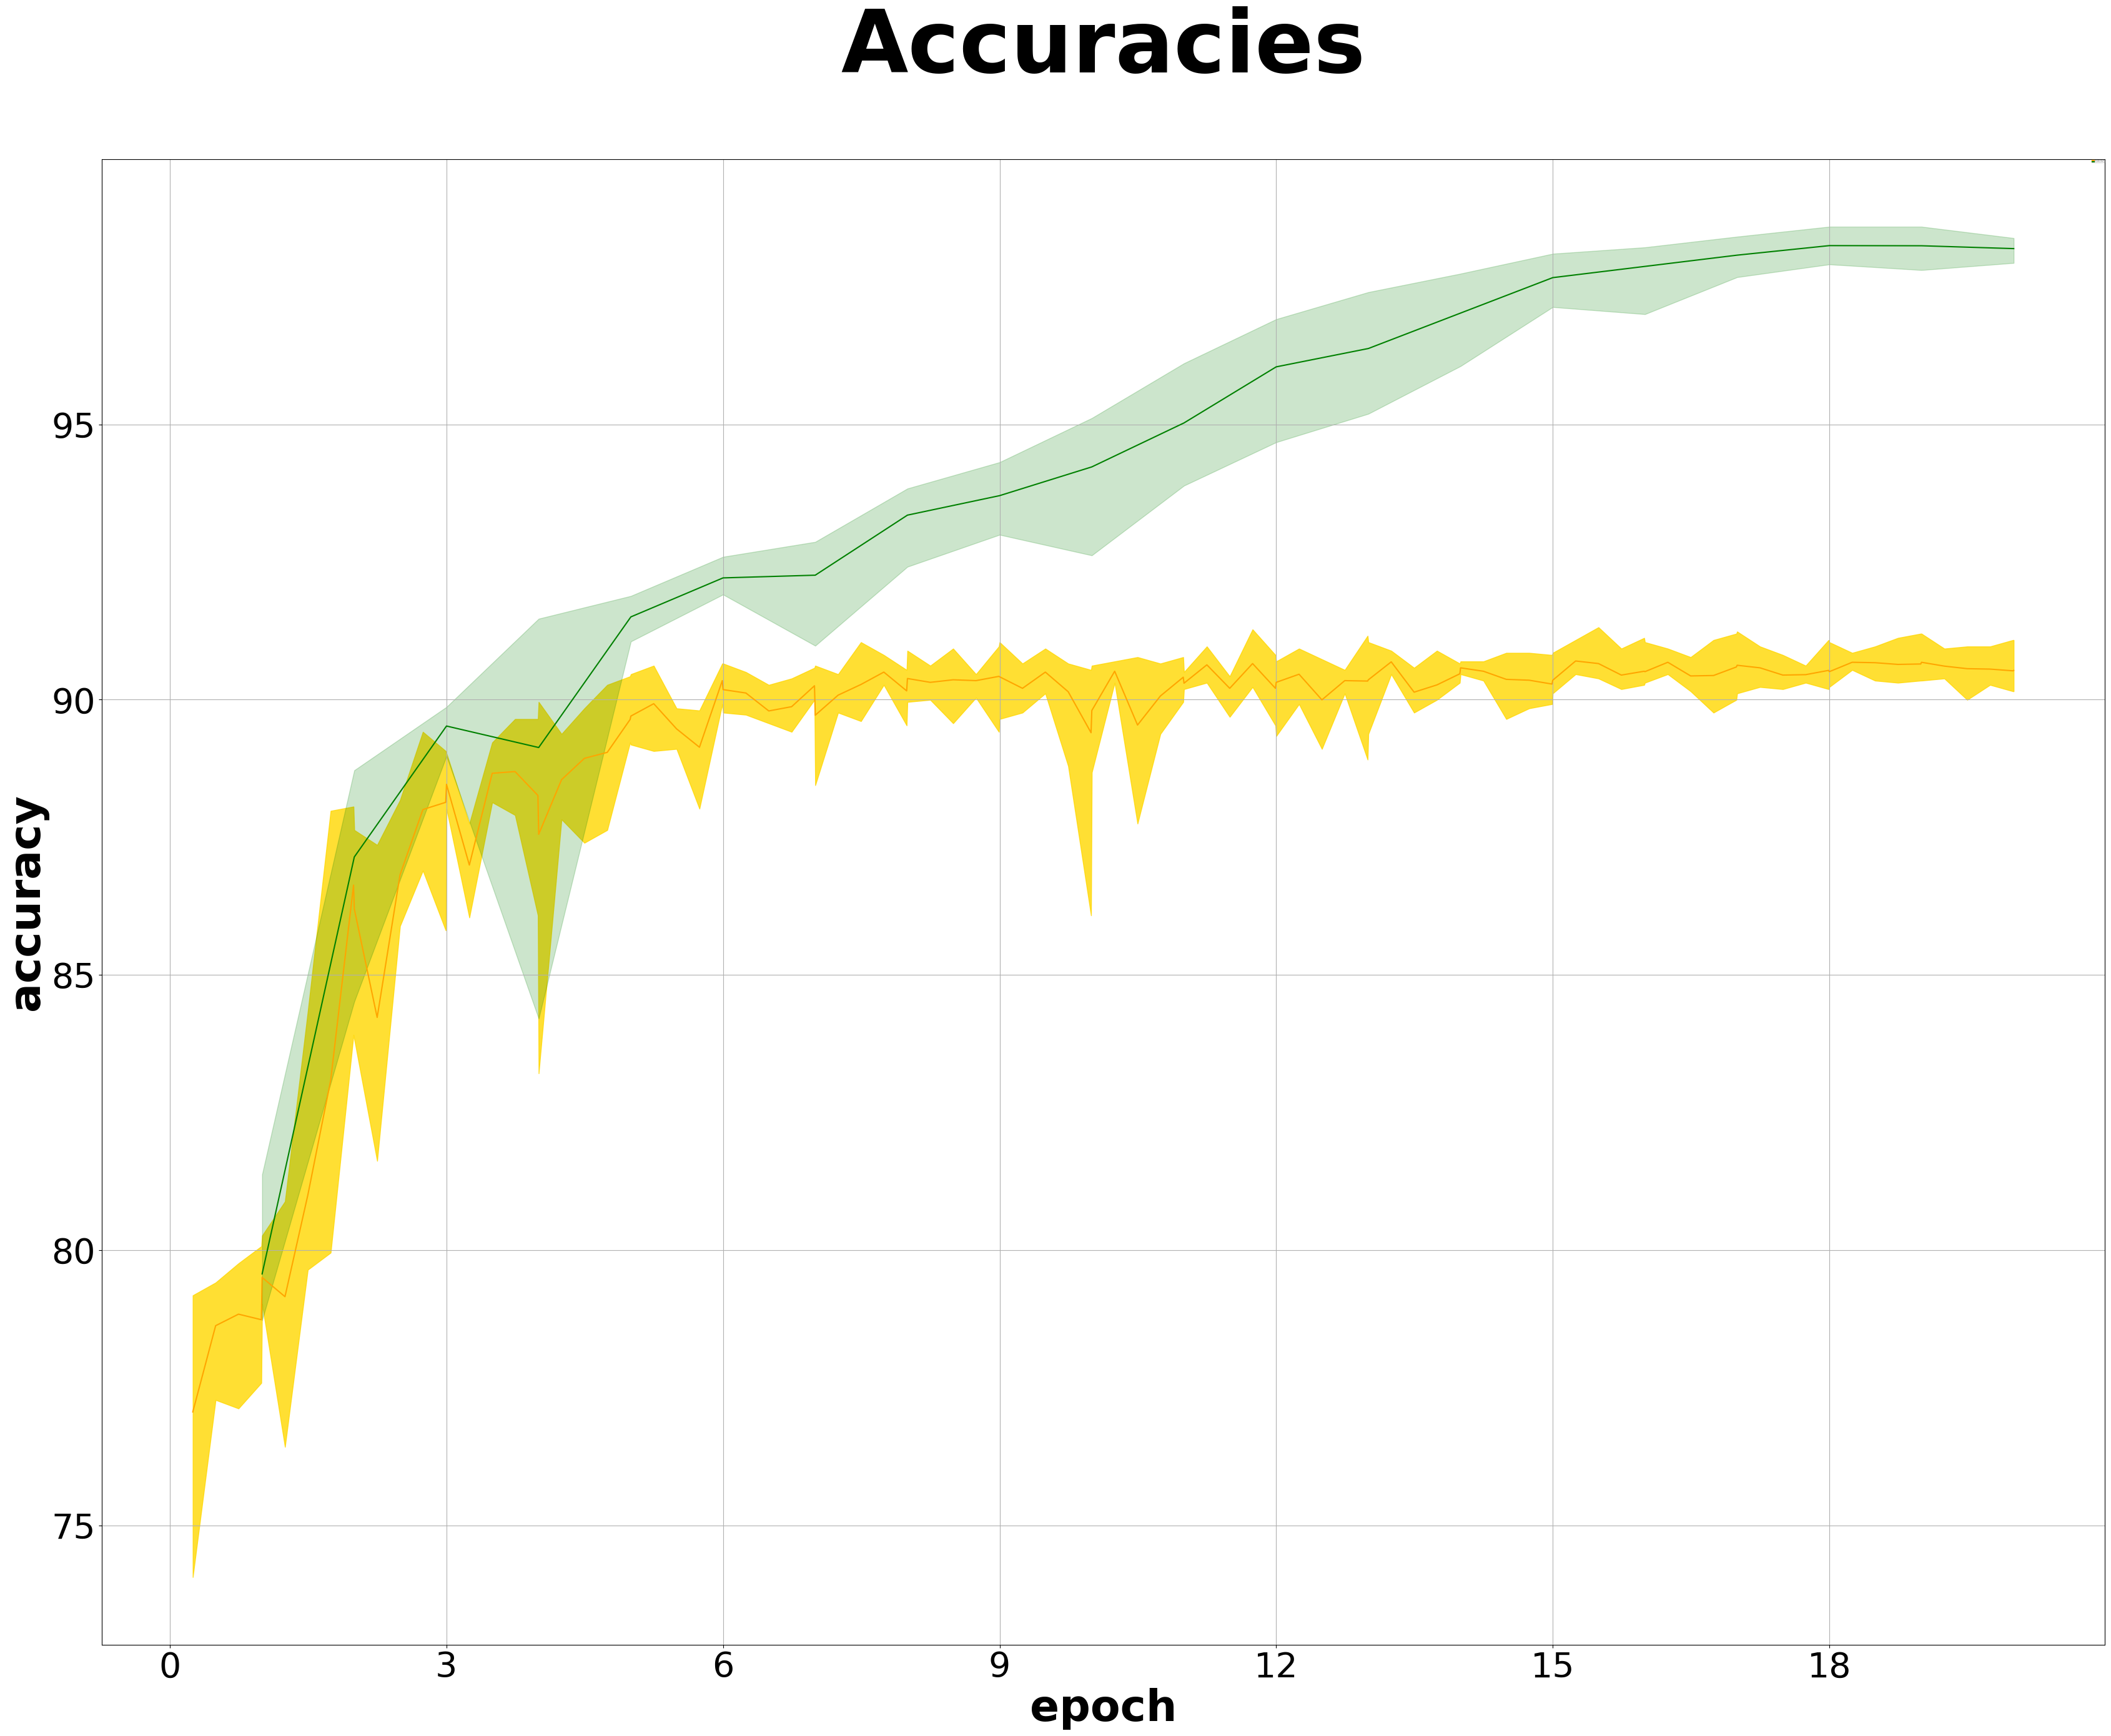

In [31]:
# Accuracies
fig, ax = plt.subplots(figsize=(36,30))
plot_exp = ax.plot(df_new["epoch"], df_new["valid_acc_mean"], 'orange',label="Validation accuracies")
ax.fill_between(df_new["epoch"], df_new["valid_acc_min"],df_new["valid_acc_max"], color='gold', alpha=0.8)
plot_exp = ax.plot(df_new_train["epoch"], df_new_train["train_acc_mean"], 'g-',label="Training accuracies")
ax.fill_between(df_new_train["epoch"], df_new_train["train_acc_min"],df_new_train["train_acc_max"], color='g', alpha=0.2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("epoch",weight="bold",fontsize=50)
plt.ylabel("accuracy",weight="bold",fontsize=50)
plt.legend()
plt.grid()
plt.title(f"Accuracies",fontsize=100,weight="bold",pad=100)
plt.tight_layout()  # Adjust layout to have space between the title and the figure
plt.show(block=False)
fig.savefig('scf-resnet9-16_accuracies.svg', format='svg')


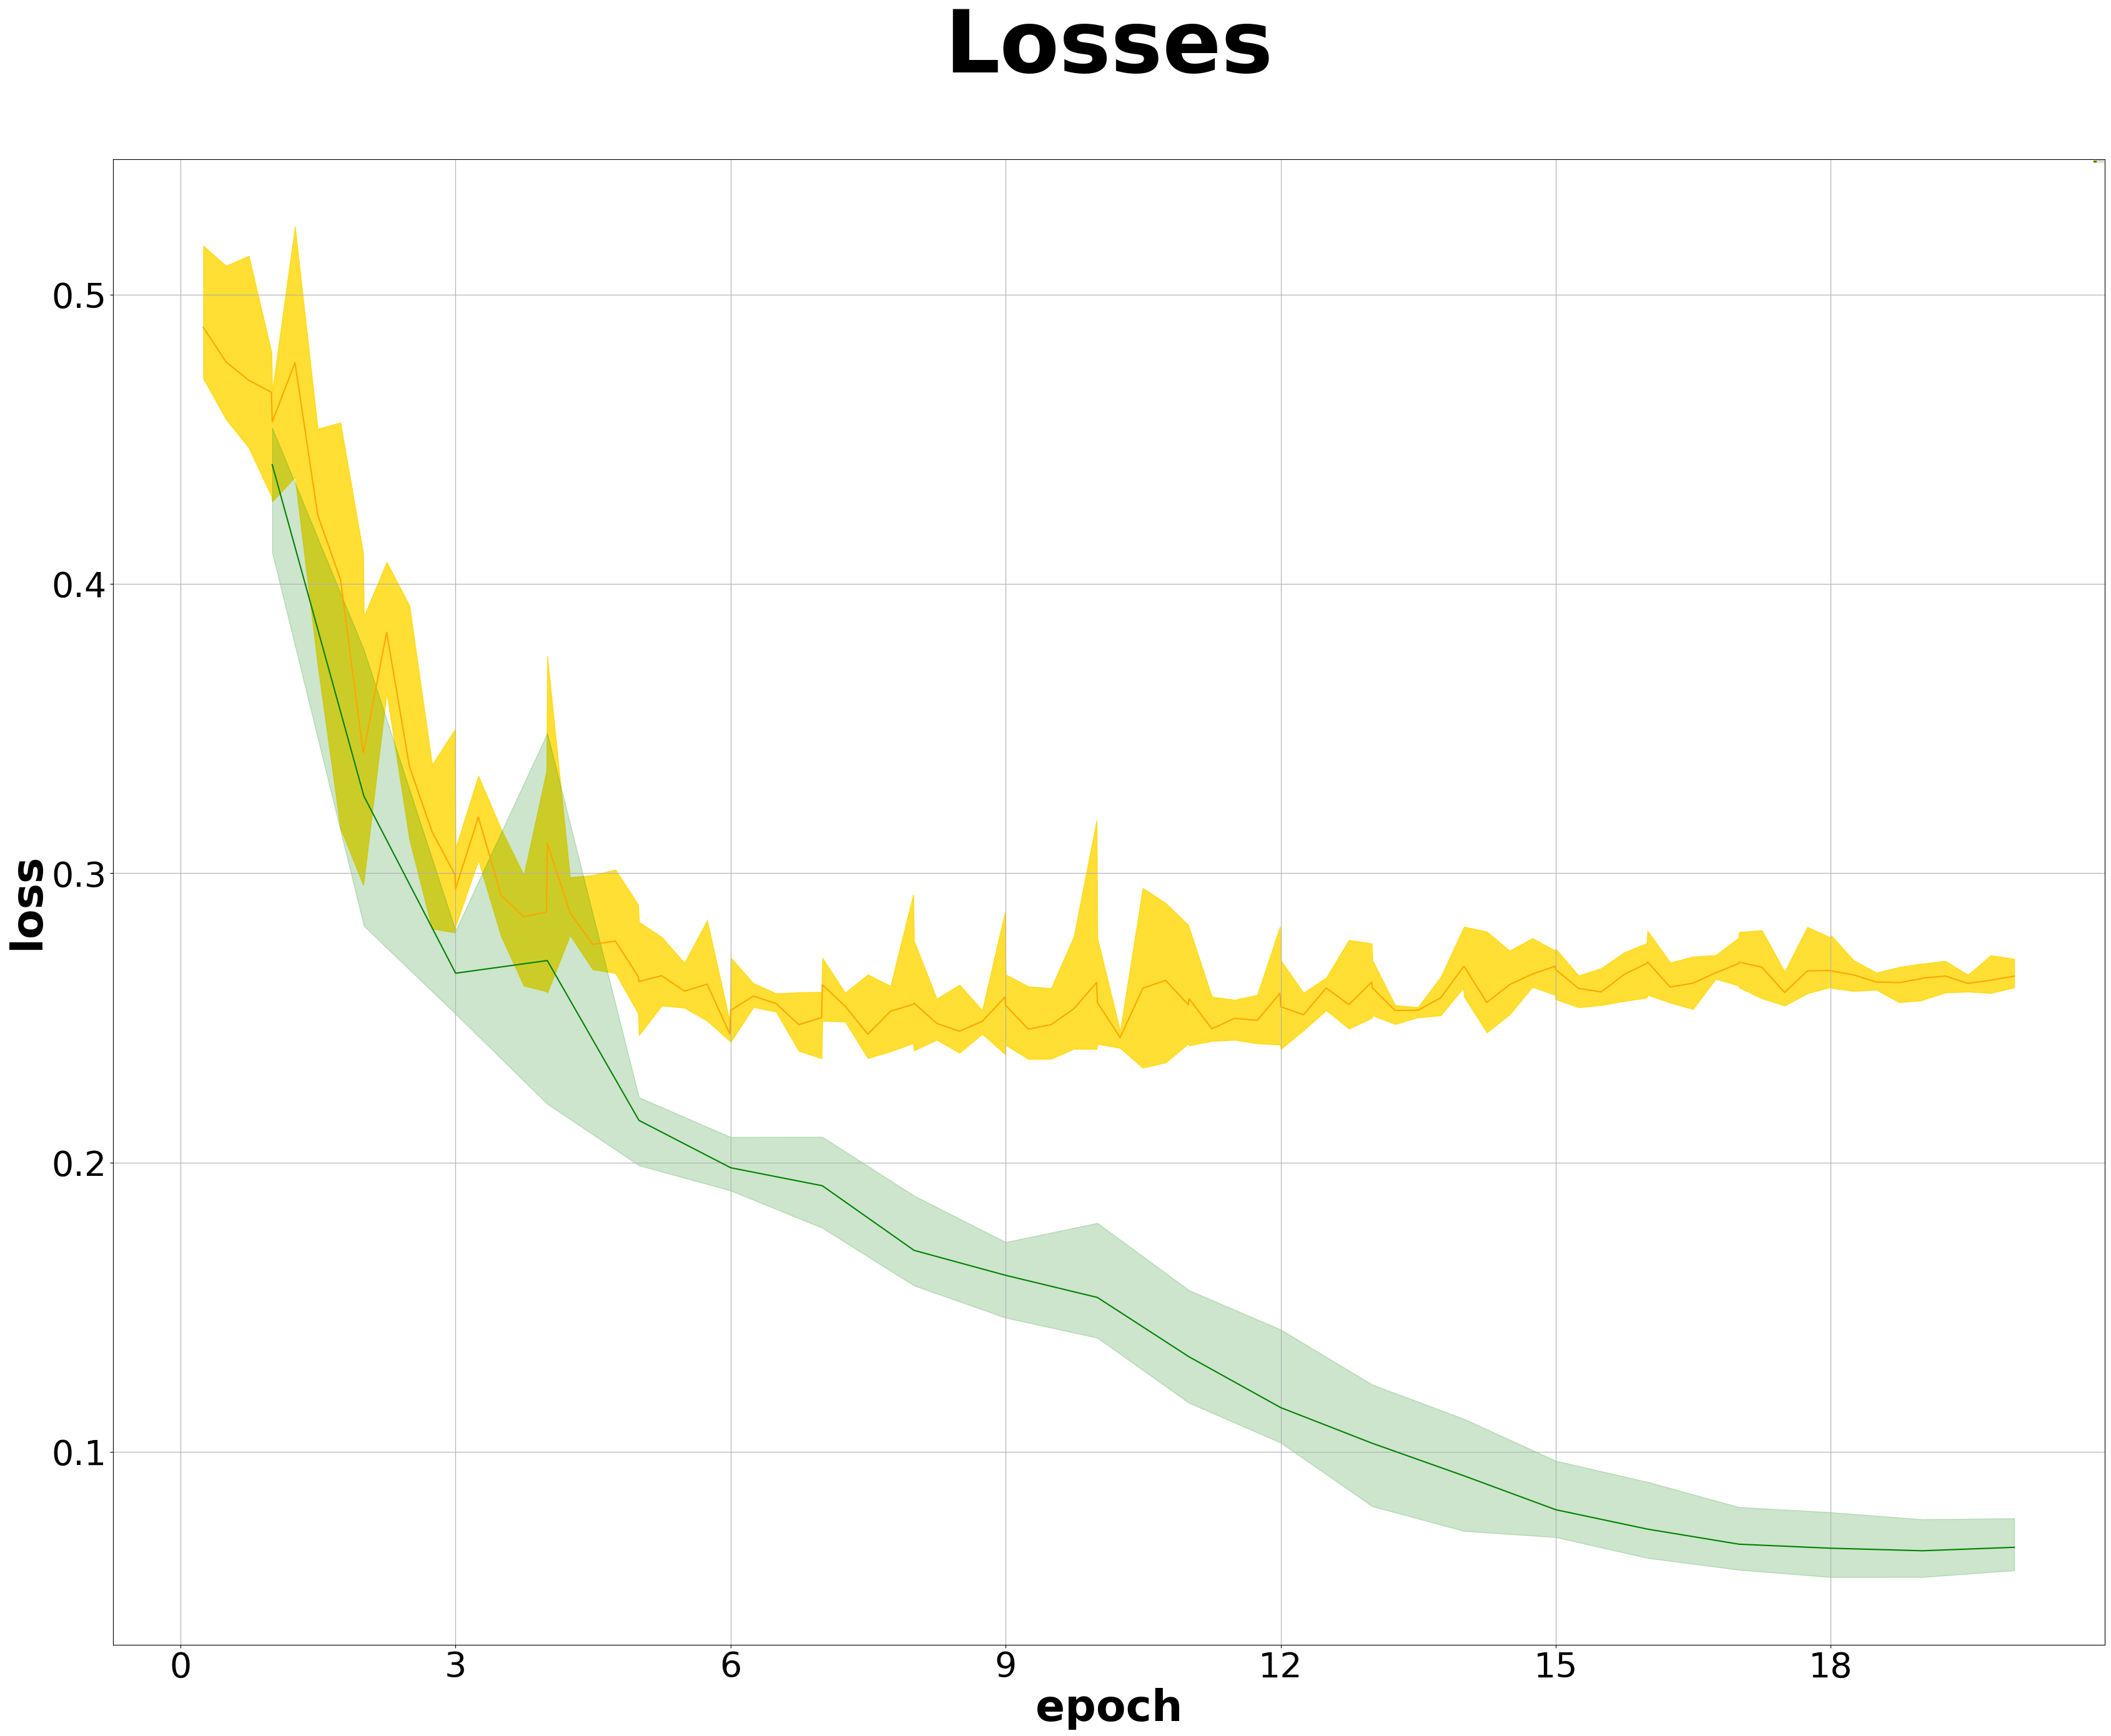

In [32]:
# Losses
fig, ax = plt.subplots(figsize=(36,30))
plot_exp = ax.plot(df_new["epoch"], df_new["valid_loss_mean"], 'orange',label="Validation losses")
ax.fill_between(df_new["epoch"], df_new["valid_loss_min"],df_new["valid_loss_max"], color='gold', alpha=0.8)
plot_exp = ax.plot(df_new_train["epoch"], df_new_train["train_loss_mean"], 'g-',label="Training losses")
ax.fill_between(df_new_train["epoch"], df_new_train["train_loss_min"],df_new_train["train_loss_max"], color='g', alpha=0.2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("epoch",weight="bold",fontsize=50)
plt.ylabel("loss",weight="bold",fontsize=50)
plt.legend()
plt.grid()
plt.title(f"Losses",fontsize=100,weight="bold",pad=100)
plt.tight_layout()  # Adjust layout to have space between the title and the figure
plt.show(block=False)
fig.savefig('scf-resnet9-16_losses.svg', format='svg')

## The best model

In [33]:
# The model with the best validation accuracy
IND = np.argmax(df_new[[f"valid_acc_{i}" for i in range(5)]].max(axis=0).values)
IND

0

In [34]:
state_dict = torch.load(f"{BEST_MODEL_FILENAME}_{IND}.pt")

In [35]:
model = ResNet9_FNO_small()

In [36]:
model.load_state_dict(state_dict)
model.to(device)
print(f"Number of the parameters: {count_parameters(model)}\n")
criterion = torch.nn.BCEWithLogitsLoss(reduction="sum").to(device)

train_loss, train_acc = evaluate(model, train_loader, criterion, device)
valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(160*"-"+"\n")
print(f"The model with the best validation accuracy:")
print(f'Train Loss: {train_loss:.3f} -  Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} - Valid Acc: {valid_acc*100:.2f}% | Test Loss: {test_loss:.3f} - Test Acc: {test_acc*100:.2f}% \t\n')

Number of the parameters: 2645537

----------------------------------------------------------------------------------------------------------------------------------------------------------------

The model with the best validation accuracy:
Train Loss: 0.072 -  Train Acc: 98.07% | Valid Loss: 0.254 - Valid Acc: 91.31% | Test Loss: 0.247 - Test Acc: 90.47% 	



In [37]:
y_preds = []
y_true = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        y_true.append(y.view(-1,1))

        x = x.to(device)
        y = y.to(device)
                
        y_pred = model(x)
            
        top_pred = (torch.sigmoid(y_pred) > 0.5).int()
        y_preds.append(top_pred.detach().cpu().view(-1,1))

y_preds = torch.cat(y_preds)
y_true = torch.cat(y_true)
results = classification_report(y_true, y_preds, target_names=target_names,output_dict=True)
print(pd.DataFrame(results).T,"\n")

              precision    recall  f1-score      support
no-whale       0.890135  0.923256  0.906393  1290.000000
whale          0.920290  0.886047  0.902844  1290.000000
accuracy       0.904651  0.904651  0.904651     0.904651
macro avg      0.905212  0.904651  0.904618  2580.000000
weighted avg   0.905212  0.904651  0.904618  2580.000000 



In [38]:
# Recall accuracy 
recall_score(y_true,y_preds)

0.8860465116279069

## Confusion matrix

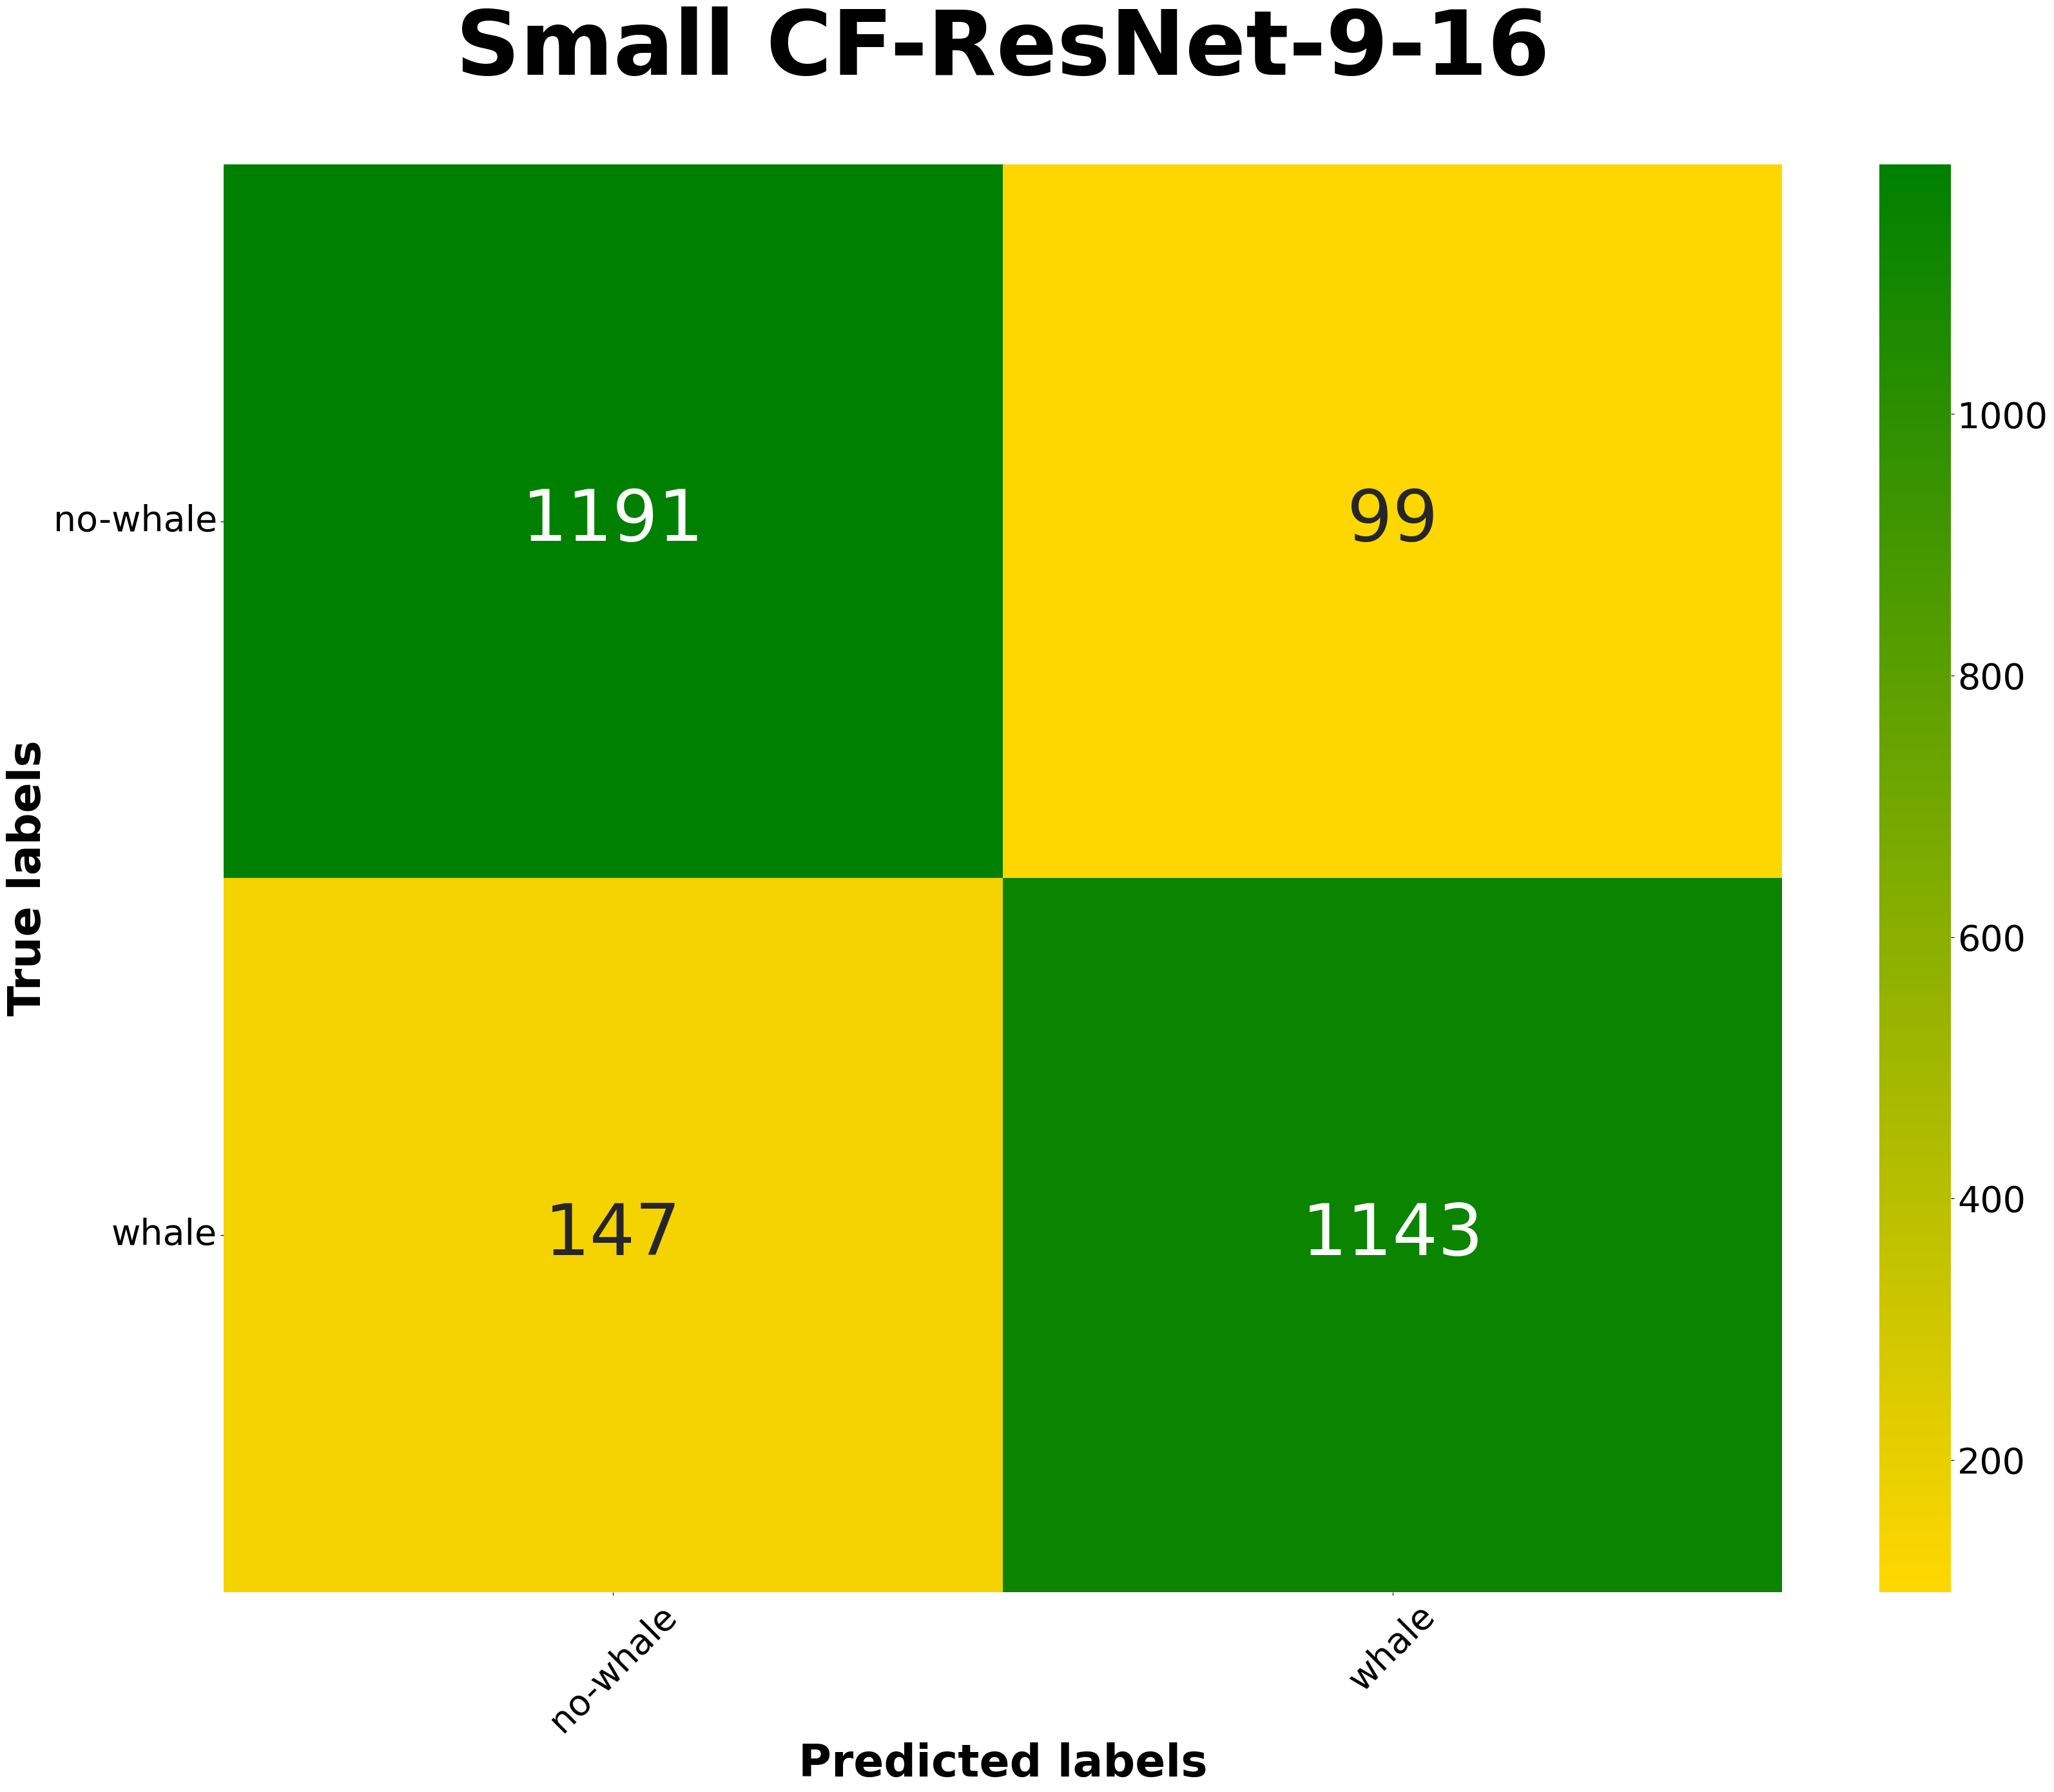

In [39]:
cm = confusion_matrix(y_true, y_preds, labels=list(range(len(target_names))))
# Adjust font sizes and styles
SMALL_SIZE = 80
MEDIUM_SIZE = 40
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=0)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=0)  # legend fontsize
plt.rc('figure', titlesize=0)  # fontsize of the figure title

# Create a custom colormap from gold to green
gold_green_cmap = LinearSegmentedColormap.from_list("gold_green", ["gold", "green"])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(36,30))
sns.heatmap(cm, annot=True, fmt='g', cmap=gold_green_cmap, ax=ax)  # Use the custom colormap

# Set axis labels and titles with bold weight and adjusted fontsize
ax.set_xlabel('Predicted labels', weight="bold", fontsize=50)
ax.set_ylabel('True labels', weight="bold", fontsize=50)
tick_marks_x = np.arange(len(target_names)) + 0.5
tick_marks_y = np.arange(len(target_names)) + 0.5

# Set tick labels
plt.xticks(tick_marks_x, target_names, rotation=45, fontsize=40)
plt.yticks(tick_marks_y, target_names, rotation=0, fontsize=40)

# Set plot title
plt.title(f"Small CF-ResNet-9-16",fontsize=100,weight="bold",pad=100)
plt.tight_layout()  # Adjust layout to have space between the title and the figure

# Display the plot
plt.show()

# Save the figure
fig.savefig('small_cf-resnet-9-16_cm.svg', format='svg')

## Accuracies among the 5 models

In [40]:
final_results = {"train_losses":[],
                 "train_accuracies":[],
                 "valid_losses":[],
                 "valid_accuracies":[],
                 "test_losses":[],
                 "test_accuracies":[],
                 "test_recalls":[]}

In [41]:
for ind in range(5):
    model = ResNet9_FNO_small()
    state_dict = torch.load(f"{BEST_MODEL_FILENAME}_{ind}.pt")
    model.load_state_dict(state_dict)
    model.to(device)
    train_loss, train_acc = evaluate(model, train_loader, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    final_results["train_losses"].append(train_loss)
    final_results["train_accuracies"].append(train_acc)
    
    final_results["valid_losses"].append(valid_loss)
    final_results["valid_accuracies"].append(valid_acc)
    
    final_results["test_losses"].append(test_loss)
    final_results["test_accuracies"].append(test_acc)
    
    y_preds = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            y_true.append(y.view(-1,1))

            x = x.to(device)
            y = y.to(device)
                
            y_pred = model(x)
            
            top_pred = (torch.sigmoid(y_pred) > 0.5).int()
            y_preds.append(top_pred.detach().cpu().view(-1,1))

        y_preds = torch.cat(y_preds)
        y_true = torch.cat(y_true)
    test_recall = recall_score(y_true,y_preds)
    
    final_results["test_recalls"].append(test_recall)
    
    print(f'Model {ind} | Train Loss: {train_loss:.3f} -  Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} - Valid Acc: {valid_acc*100:.2f}% | Test Loss: {test_loss:.3f} - Test Acc: {test_acc*100:.2f}% \t')

Model 0 | Train Loss: 0.072 -  Train Acc: 98.07% | Valid Loss: 0.254 - Valid Acc: 91.31% | Test Loss: 0.247 - Test Acc: 90.47% 	
Model 1 | Train Loss: 0.169 -  Train Acc: 93.33% | Valid Loss: 0.236 - Valid Acc: 91.04% | Test Loss: 0.224 - Test Acc: 90.50% 	
Model 2 | Train Loss: 0.142 -  Train Acc: 94.71% | Valid Loss: 0.245 - Valid Acc: 90.97% | Test Loss: 0.235 - Test Acc: 90.85% 	
Model 3 | Train Loss: 0.127 -  Train Acc: 95.50% | Valid Loss: 0.241 - Valid Acc: 91.28% | Test Loss: 0.231 - Test Acc: 90.62% 	
Model 4 | Train Loss: 0.149 -  Train Acc: 94.31% | Valid Loss: 0.241 - Valid Acc: 91.00% | Test Loss: 0.232 - Test Acc: 90.70% 	


In [42]:
print(f"Mean test accuracy: {np.mean(final_results['test_accuracies']):.4f}")
print(f"Mean test recall: {np.mean(final_results['test_recalls']):.4f}")

Mean test accuracy: 0.9063
Mean test recall: 0.8806


In [43]:
pd.DataFrame(y_test).value_counts()

0    1290
1    1290
Name: count, dtype: int64

In [44]:
data_test = pd.read_csv(TEST_DATASET,sep=",")
#columns = data_test.columns
data_test[columns[-1]]=data_test[columns[-1]].replace(target_names_dict)
data_test = data_test.values
data_test_labels = data_test[:,-1].reshape(-1)
data_test_labels = data_test_labels.astype(int)
data_test = data_test[:,:-1]

In [45]:
pd.DataFrame(data_test_labels).value_counts()

0    1290
1    1290
Name: count, dtype: int64